# Setup
https://github.com/RobinMagnet/pyFM

```
conda activate
juptyer notebook
```

In [12]:
import numpy as np
from stl import mesh

In [13]:
from pyFM.mesh import TriMesh
from pyFM.functional import FunctionalMapping

import meshplot as mp

def plot_mesh(myMesh,cmap=None):
    mp.plot(myMesh.vertlist, myMesh.facelist,c=cmap)
    
def double_plot(myMesh1,myMesh2,cmap1=None,cmap2=None):
    d = mp.subplot(myMesh1.vertlist, myMesh1.facelist, c=cmap1, s=[2, 2, 0])
    mp.subplot(myMesh2.vertlist, myMesh2.facelist, c=cmap2, s=[2, 2, 1], data=d)

def visu(vertices):
    min_coord,max_coord = np.min(vertices,axis=0,keepdims=True),np.max(vertices,axis=0,keepdims=True)
    cmap = (vertices-min_coord)/(max_coord-min_coord)
    return cmap

# Load palpation pointcloud
https://github.com/OpenTopography/PointCloud_to_STL/blob/main/OT_VoxeltoSTL.ipynb

In [14]:
points = np.loadtxt("data/manual_palpation_1.csv", dtype=float, delimiter=',', 
                    skiprows=1, #Skip header
                    usecols=(7,8,9)) #Translations
# display(points)
print("Number of points in original file:",len(points))

Number of points in original file: 332


## Grid Sampling of Point Cloud
Using cubic cells called voxels, for each voxel, we use one representative point. This point may be the barycenter of the points in the cell, or the point that is closest to the barycenter.

Change the "voxel_size" to vary subset resolution.

Note: voxel_size is in Meters

In [15]:
voxel_size=0.001
nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
print("The voxel grid is X,Y,Z voxels:", (nb_vox))

The voxel grid is X,Y,Z voxels: [106. 109.  25.]


Let's get a sense of how much the point cloud data will be reduced, both by point number and percentage of overall data subset into this new dataset.

NOTE: If the subset percentage is negative, increase your voxel size as your voxel is smaller than collected data resolution.

In [16]:
nb_vox_readout = np.prod(nb_vox, dtype=int) 
print("This will reduce number of points to", nb_vox_readout)

pts_length = len(points)
perct = ((1-(nb_vox_readout/pts_length))*100)
print("Or reduce by", perct, "%")

This will reduce number of points to 288850
Or reduce by -86903.01204819277 %


### Define the function.
Within this function, each voxel is tested to see if it contains one or more points. Voxels that have points are kept in the set, and empty voxels are indexed. It then computes the point data that will be used to represent each individual voxel.

In [17]:
#Define a function that takes as input an array of points, and a voxel size expressed in meters. It returns the sampled point cloud
def grid_subsampling(points, voxel_size):

  nb_vox=np.ceil((np.max(points, axis=0) - np.min(points, axis=0))/voxel_size)
  non_empty_voxel_keys, inverse, nb_pts_per_voxel= np.unique(((points - np.min(points, axis=0)) // voxel_size).astype(int), axis=0, return_inverse=True, return_counts=True)
  idx_pts_vox_sorted=np.argsort(inverse)
  voxel_grid={}
  grid_barycenter,grid_candidate_center=[],[]
  last_seen=0

  for idx,vox in enumerate(non_empty_voxel_keys):
    voxel_grid[tuple(vox)]=points[idx_pts_vox_sorted[last_seen:last_seen+nb_pts_per_voxel[idx]]]
    grid_barycenter.append(np.mean(voxel_grid[tuple(vox)],axis=0))
    grid_candidate_center.append(voxel_grid[tuple(vox)][np.linalg.norm(voxel_grid[tuple(vox)]-np.mean(voxel_grid[tuple(vox)],axis=0),axis=1).argmin()])
    last_seen+=nb_pts_per_voxel[idx]

  return grid_candidate_center

Execute the function with the original point cloud data set and voxel size established previously.

In [18]:
grid_sampled_point_cloud = grid_subsampling(points, voxel_size)
grid_sample_pc_np = np.array(grid_sampled_point_cloud)

Load in a TriMesh

In [19]:
mesh2=TriMesh(grid_sample_pc_np, center=False)

### Visualization
**Subsampled Point Cloud Plotting**

To view all points in subset dataset.


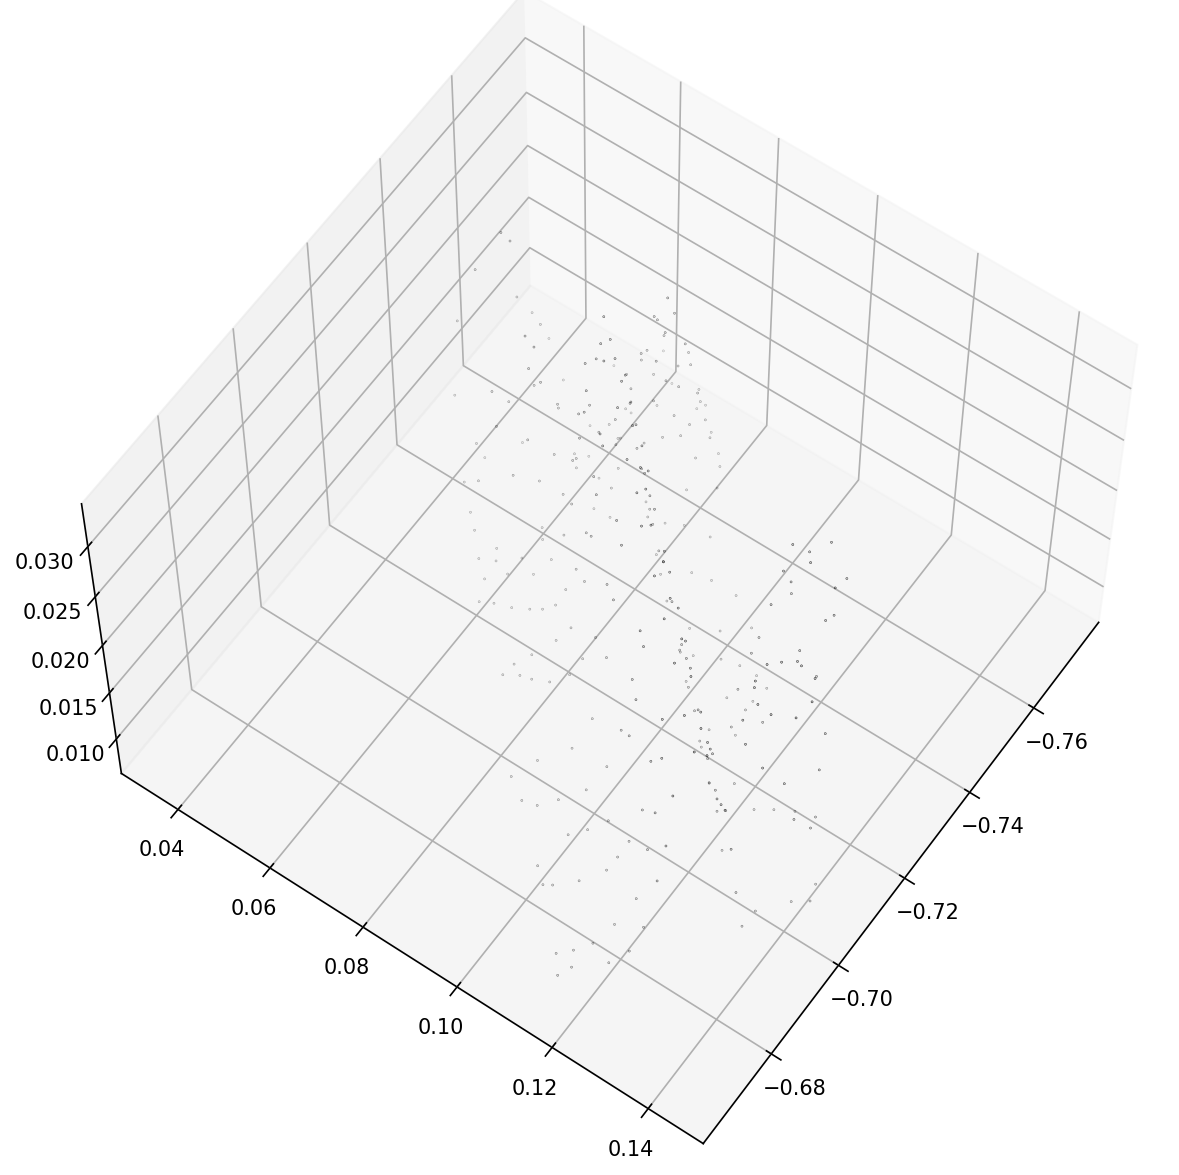

In [20]:
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=150)

ax = plt.axes(projection='3d')
ax.scatter(grid_sample_pc_np[:,0], grid_sample_pc_np[:,1], grid_sample_pc_np[:,2], s = 0.05, c = 'black')
ax.view_init(60, 35)
plt.show()

**Triangulating for surface output**

Create a surface by triangulating between every 3 adjacent points. This type of surfacing may be best for natural features

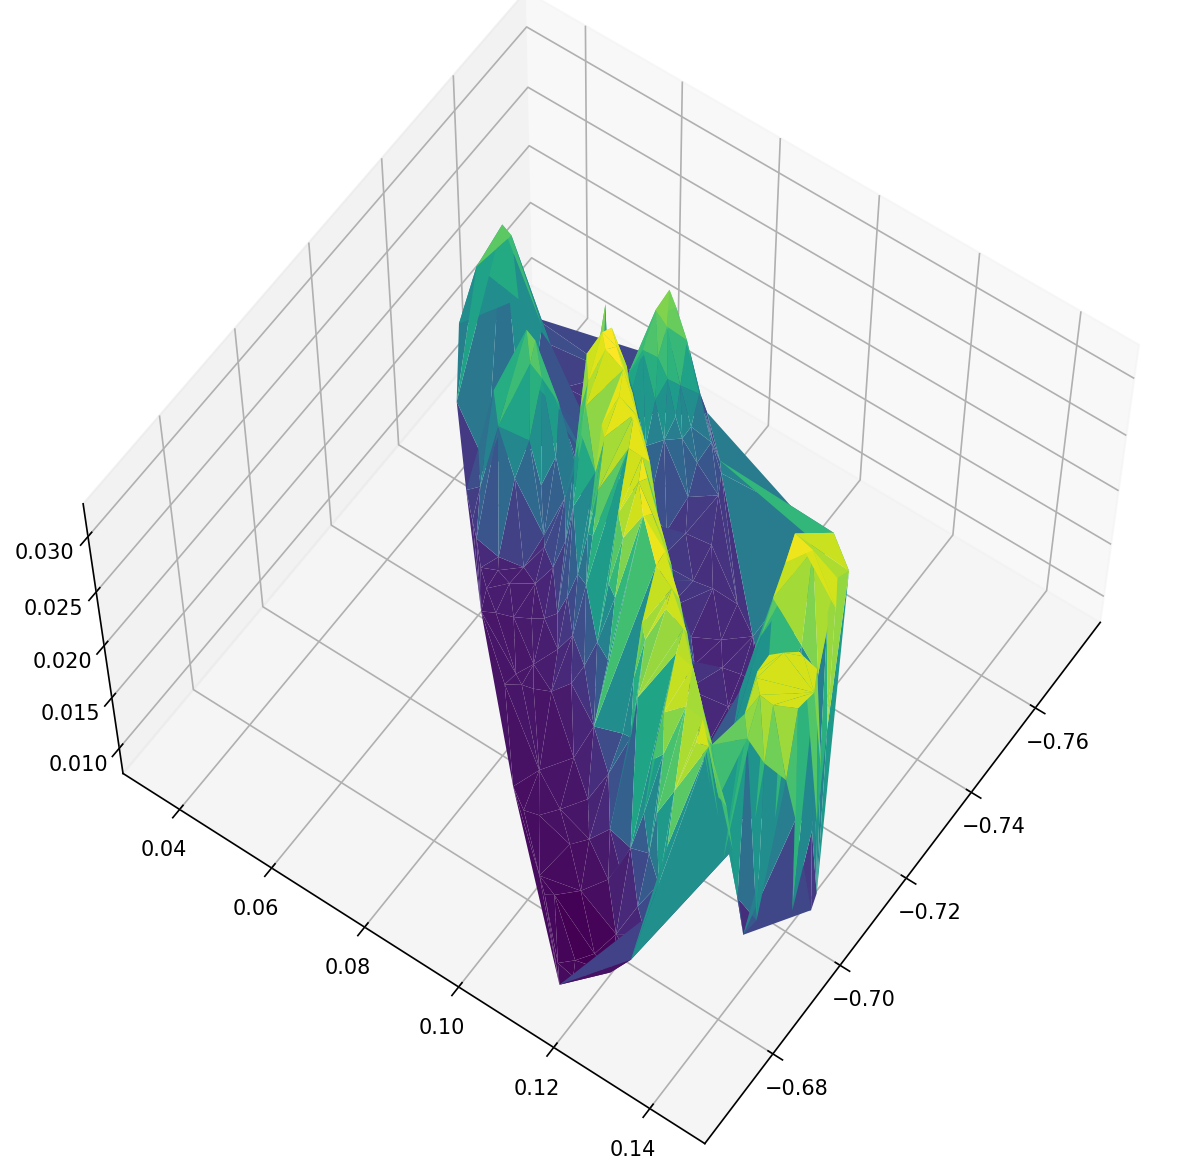

In [21]:
from matplotlib.pyplot import figure
figure(figsize=(12, 10), dpi=150)

ax = plt.axes(projection='3d')
trisurf = ax.plot_trisurf(grid_sample_pc_np[:,0], grid_sample_pc_np[:,1], grid_sample_pc_np[:,2], 
                ax.view_init(60, 35), cmap='viridis', edgecolor='none');

# Load model

## Convert STL to OFF

(Might not depending on encoding...) From https://github.com/tforgione/model-converter-python :
python3 convert.py -i ../data/palpation_part1.stl -o ../data/palpation.off



In the meantime : https://imagetostl.com/convert/file/stl/to/off

## Load mesh

In [43]:
mesh1 = TriMesh('data/palpation.off', area_normalize=True, center=False)

# Compute functional map

**Display meshes data**

In [31]:
print(f'Mesh 1 : {mesh1.n_vertices:4d} vertices, {mesh1.n_faces:5d} faces\n'
      f'Mesh 2 : {mesh2.n_vertices:4d} vertices, {mesh2.n_faces:5d} faces')
double_plot(mesh1, mesh2)

Mesh 1 : 1648 vertices,  3292 faces
Mesh 2 :  331 vertices,     0 faces


**Computing descriptors**

In [32]:
process_params = {
    'n_ev': (35,35),  # Number of eigenvalues on source and Target
    # 'landmarks': np.loadtxt('data/landmarks.txt',dtype=int)[:5],  # loading 5 landmarks
    'subsample_step': 5,  # In order not to use too many descriptors
    'descr_type': 'WKS',  # WKS or HKS
}

model = FunctionalMapping(mesh1,mesh2)
model.preprocess(**process_params,verbose=True);


Computing Laplacian spectrum
Computing 200 eigenvectors
	Done in 0.27 s
Computing 200 eigenvectors
	Done in 0.08 s

Computing descriptors
	Normalizing descriptors

	20 out of 100 possible descriptors kept


**Fitting the model**

In [33]:
fit_params = {
    'w_descr': 1e0,
    'w_lap': 1e-2,
    'w_dcomm': 1e-1,
    'w_orient': 0
}



model.fit(**fit_params, verbose=True)

Computing commutativity operators
	Scaling LBO commutativity weight by 2.6e-12

Optimization :
	35 Ev on source - 35 Ev on Target
	Using 20 Descriptors
	Hyperparameters :
		Descriptors preservation :1.0e+00
		Descriptors commutativity :1.0e-01
		Laplacian commutativity :1.0e-02
		Orientation preservation :0.0e+00

	Task : CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH, funcall : 31, nit : 26, warnflag : 0
	Done in 0.04 seconds


**Visualizing the associated point to point map**

In [34]:
p2p_21 = model.get_p2p(n_jobs=1)
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21]
double_plot(mesh1,mesh2,cmap1,cmap2)

/home/antoineh/.local/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


## Refinining the Functioal Map

**ICP**

In [35]:
model.icp_refine(verbose=True)
p2p_21_icp = model.get_p2p()
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_icp]
double_plot(mesh1,mesh2,cmap1,cmap2)

  0%|          | 0/10 [00:00<?, ?it/s]

/home/antoineh/.local/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)


**Zoomout**

In [36]:
model.change_FM_type('classic') # We refine the first computed map, not the icp-refined one
model.zoomout_refine(nit=15, step = 1, verbose=True)
print(model.FM.shape)
p2p_21_zo = model.get_p2p()
cmap1 = visu(mesh1.vertlist); cmap2 = cmap1[p2p_21_zo]
double_plot(mesh1,mesh2,cmap1,cmap2)

  0%|          | 0/15 [00:00<?, ?it/s]

(50, 50)


/home/antoineh/.local/lib/python3.9/site-packages/jupyter_client/session.py:718: UserWarning: Message serialization failed with:
Out of range float values are not JSON compliant
Supporting this message is deprecated in jupyter-client 7, please make sure your message is JSON-compliant
  content = self.pack(content)
